---
```
Name: Omer Farooq
Student ID: OME23629652
Course: Deep Learning Applications - CMP020L016
```
---

# Fashion MNIST Classification with PyTorch  

In this project, I used PyTorch to classify images from the Fashion MNIST dataset.  
I loaded the dataset, applied transformations, and prepared it for training.  
The goal is to train a deep learning model to recognize different clothing items.  
Visualization tools like Matplotlib and Seaborn help analyze results, including the confusion matrix.  


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import itertools
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Define Hyperparameters
batch_size = 50
num_classes = 10
epochs = 30
learning_rate = 0.001
# Define class labels for Fashion MNIST
LABELS = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}



## Setting parameters  

To train the deep learning model, I defined key parameters:  
- **Batch size:** 50 (number of images processed at once)  
- **Learning rate:** 0.001 (controls how much weights update per step)  
- **Epochs:** 30 (number of times the model sees the full dataset)  

Fashion MNIST has **10 classes**, including T-shirts, trousers, dresses, and sneakers.  
These labels help interpret model predictions.  


In [4]:
# Define Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Dataset
train_dataset = FashionMNIST(root="data", train=True, transform=transform, download=True)
test_dataset = FashionMNIST(root="data", train=False, transform=transform, download=True)

# Split Training Dataset into Train and Validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 26.4M/26.4M [00:01<00:00, 14.1MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.28MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## Data Preparation  

To prepare the Fashion MNIST dataset, I applied the following transformations:  
- **Convert to Tensor:** Changes images into a format suitable for PyTorch.  
- **Normalize:** Scales pixel values to the range (-1, 1) for better training stability.  

I loaded the dataset and split the training data into **80% training** and **20% validation**.  
Data loaders were created to efficiently feed batches of images into the model.  


In [5]:
# Extract labels for training and test sets
Y_train = np.array([train_dataset[i][1] for i in range(len(train_dataset))])
Y_test = np.array([test_dataset[i][1] for i in range(len(test_dataset))])
# Count occurrences of each class
train_class_counts = {label: (Y_train == i).sum() for i, label in LABELS.items()}
test_class_counts = {label: (Y_test == i).sum() for i, label in LABELS.items()}

# Function to plot the class distribution
def plot_class_distribution(class_counts, title):
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(y=list(class_counts.values()), x=list(class_counts.keys()), palette="magma")

    # Annotate bars with count values
    for i, v in enumerate(class_counts.values()):
        ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)

    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()



## Exploring Class Distribution  

I extracted labels from the training and test datasets to analyze the class distribution.  
This helps ensure the dataset is balanced and that all categories are well-represented.  

A bar chart is plotted using **Seaborn** to visualize the number of images in each class.  
This insight is crucial for detecting class imbalances that might affect model performance.  
and as noticed all features is equal

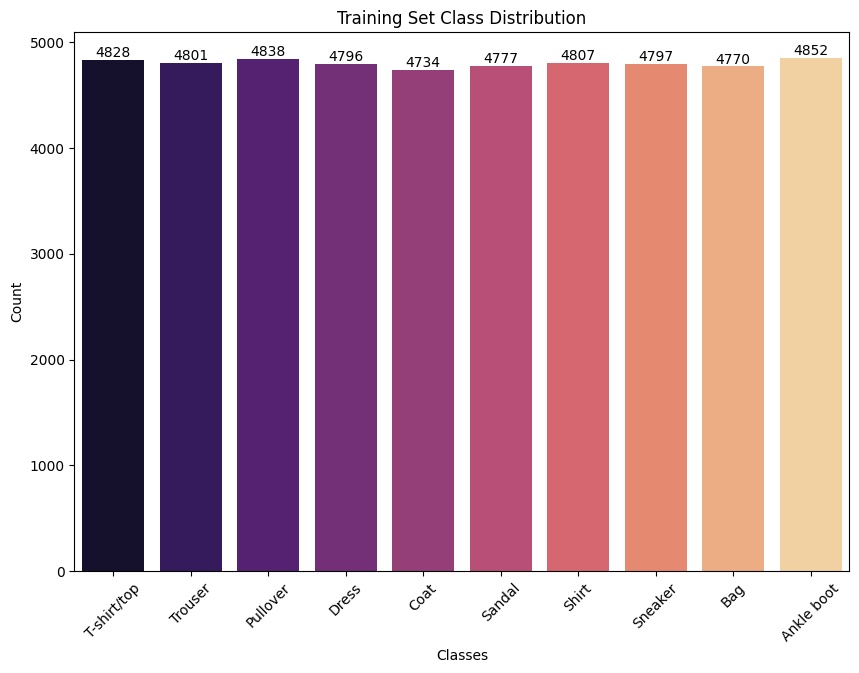

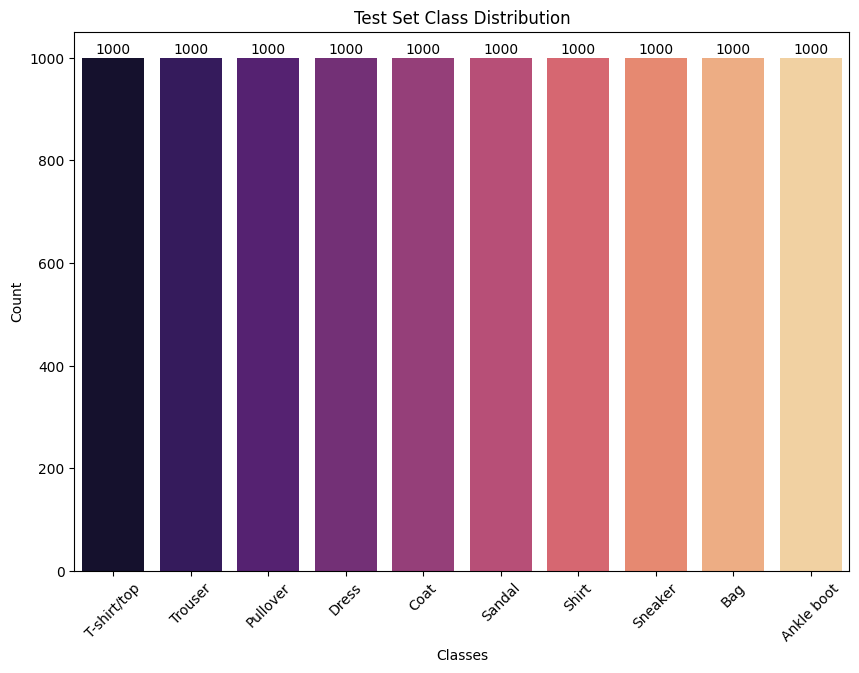

In [6]:
# Plot distributions for Training and Test sets
plot_class_distribution(train_class_counts, "Training Set Class Distribution")
plot_class_distribution(test_class_counts, "Test Set Class Distribution")


## Visualizing Sample Images  

To understand the dataset better, I extracted and displayed **25 sample images** from the training set.  
Each image is shown in grayscale with its corresponding class label.  

This visualization helps verify that the data is correctly loaded and labeled before training the model.  


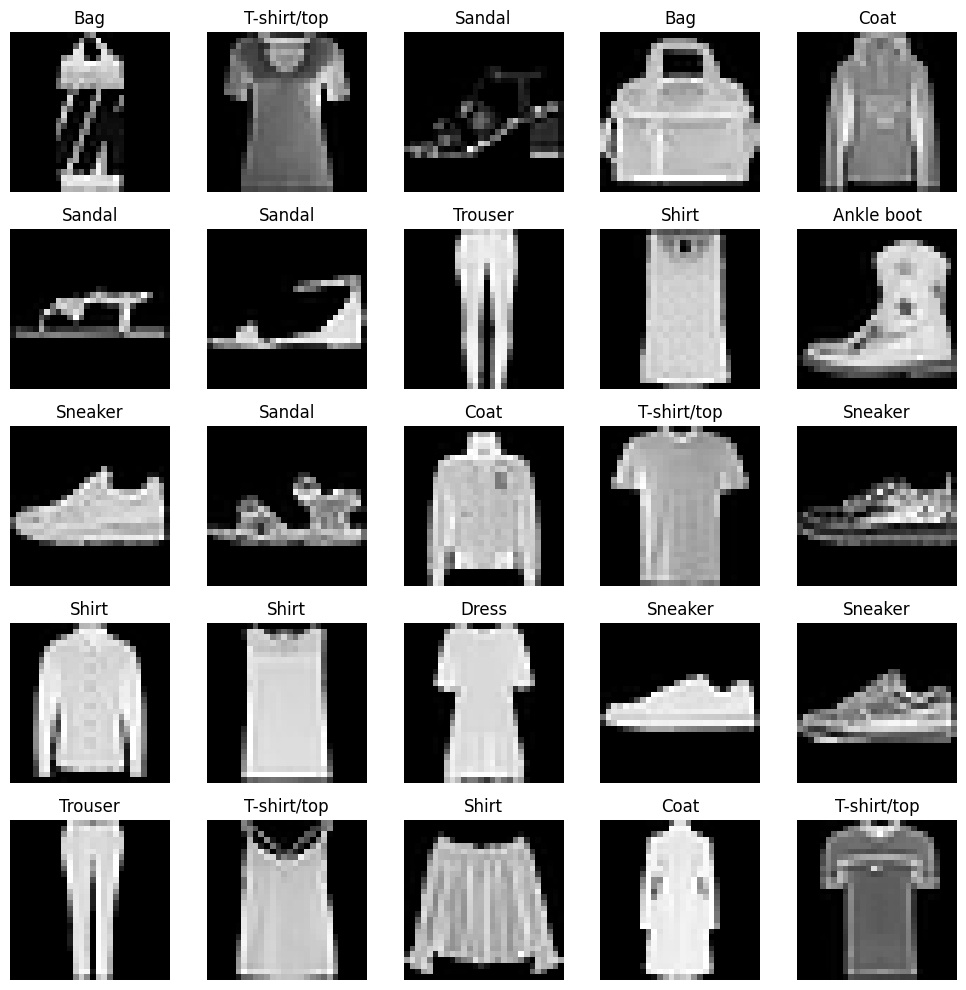

In [7]:
# Extract images for visualization
X_train = np.array([train_dataset[i][0].numpy().squeeze() for i in range(len(train_dataset))])

# Plot 5×5 grid of sample images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = X_train[i]
    label = LABELS[Y_train[i]]
    ax.imshow(img, cmap="gray")
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Define CNN Model
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.5)

        # Compute dynamically the input size for fc1
        self._to_linear = None  # Placeholder
        self._compute_linear_input()

        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, 10)

    def _compute_linear_input(self):
        """Compute the number of flattened features dynamically."""
        with torch.no_grad():
            sample_input = torch.zeros(1, 1, 28, 28)
            output = self.pool(torch.relu(self.conv1(sample_input)))
            output = self.dropout(output)
            output = self.pool(torch.relu(self.conv2(output)))
            output = self.dropout(output)
            output = self.pool(torch.relu(self.conv3(output)))
            output = self.dropout(output)
            # Get the total number of features
            self._to_linear = output.numel()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.dropout(x)

        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


## Building the CNN Model  

I designed a **Convolutional Neural Network (CNN)** to classify Fashion MNIST images.  
The architecture includes:  
- **Three convolutional layers** to extract features from images.  
- **Max pooling layers** to reduce spatial dimensions.  
- **Dropout layers** (50%) to prevent overfitting.  
- **Fully connected layers** to make final predictions.  

A helper function dynamically computes the input size for the fully connected layer,  
ensuring flexibility in processing input dimensions.  


In [9]:
# Initialize Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FashionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
# Evaluation Function
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

## Model Evaluation Function  

An evaluation function is defined to assess the model's performance on a given dataset.  
The process involves:  
- Setting the model to **evaluation mode** to disable dropout layers.  
- Disabling gradient calculations to improve efficiency.  
- Making predictions and calculating **accuracy** based on correct classifications.  

This function is used to evaluate the model on the **validation and test datasets**.  


## Model Initialization  

The **FashionCNN** model is initialized and assigned to the available device (**GPU if available, otherwise CPU**).  
For training, the following configurations are used:  
- **Cross-Entropy Loss** is selected as the loss function for multi-class classification.  
- **Adam Optimizer** is used with a learning rate of **0.001** to adjust model weights efficiently.  

This setup ensures stable and effective learning during training.  


In [10]:
# Training Function with Loss & Accuracy Tracking
def train_model(model, train_loader, val_loader, epochs):
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_acc)

        val_acc = evaluate_model(model, val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    return train_losses, train_accuracies


## Training Function  

A function is defined to train the **FashionCNN** model while tracking **loss and accuracy**.  
The training process includes:  
- Setting the model to **training mode**.  
- Performing **forward and backward propagation** to update weights.  
- Computing the **training loss** and **accuracy** after each epoch.  
- Evaluating the model on the **validation set** to monitor performance.  

The function returns **training losses and accuracies** for further analysis.  


In [12]:
# Train the Model
# Train the Model & Get Metrics
train_losses, train_accuracies = train_model(model, train_loader, val_loader, epochs)

Epoch 1/30, Loss: 0.6972, Train Acc: 0.7411, Val Acc: 0.8464
Epoch 2/30, Loss: 0.4688, Train Acc: 0.8276, Val Acc: 0.8685
Epoch 3/30, Loss: 0.4225, Train Acc: 0.8464, Val Acc: 0.8876
Epoch 4/30, Loss: 0.3929, Train Acc: 0.8573, Val Acc: 0.8943
Epoch 5/30, Loss: 0.3788, Train Acc: 0.8628, Val Acc: 0.8964
Epoch 6/30, Loss: 0.3653, Train Acc: 0.8670, Val Acc: 0.8911
Epoch 7/30, Loss: 0.3591, Train Acc: 0.8698, Val Acc: 0.9033
Epoch 8/30, Loss: 0.3473, Train Acc: 0.8737, Val Acc: 0.9028
Epoch 9/30, Loss: 0.3388, Train Acc: 0.8764, Val Acc: 0.9055
Epoch 10/30, Loss: 0.3360, Train Acc: 0.8783, Val Acc: 0.9078
Epoch 11/30, Loss: 0.3285, Train Acc: 0.8796, Val Acc: 0.9071
Epoch 12/30, Loss: 0.3263, Train Acc: 0.8816, Val Acc: 0.9107
Epoch 13/30, Loss: 0.3214, Train Acc: 0.8836, Val Acc: 0.9115
Epoch 14/30, Loss: 0.3237, Train Acc: 0.8833, Val Acc: 0.9100
Epoch 15/30, Loss: 0.3203, Train Acc: 0.8848, Val Acc: 0.9134
Epoch 16/30, Loss: 0.3165, Train Acc: 0.8849, Val Acc: 0.9126
Epoch 17/30, Loss

## Model Training Results  

The **FashionCNN** model is trained for **30 epochs**, and the training progress is recorded.  
Key observations from the final epochs:  
- **Training Accuracy:** **89.21%**, indicating strong learning.  
- **Validation Accuracy:** **91.73%**, showing good generalization to unseen data.  
- **Final Loss:** **0.3021**, suggesting stable convergence.  

The results demonstrate that the model effectively classifies Fashion MNIST images.  


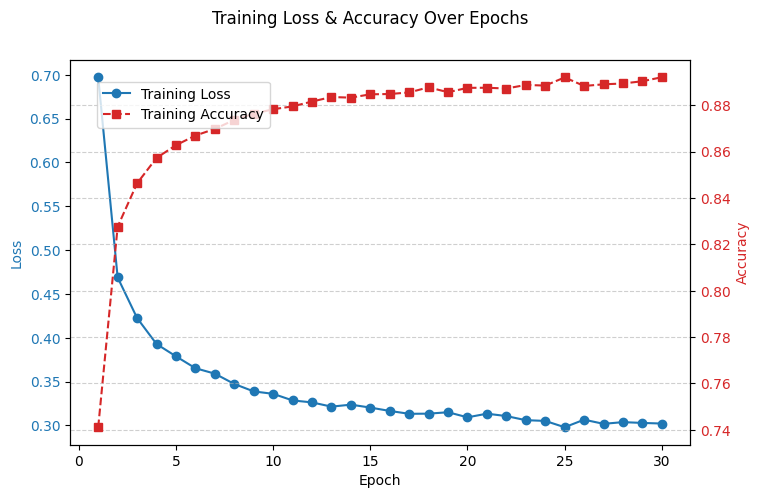

In [13]:

# Plot Training Loss and Accuracy
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Loss (Left Axis)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color="tab:blue")
ax1.plot(range(1, epochs + 1), train_losses, label="Training Loss", color="tab:blue", marker="o", linestyle="-")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Plot Accuracy (Right Axis)
ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color="tab:red")
ax2.plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy", color="tab:red", marker="s", linestyle="--")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Title & Legend
fig.suptitle("Training Loss & Accuracy Over Epochs")
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85))
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


## Training Loss & Accuracy Plot  

The graph illustrates the **training loss** and **accuracy** over **30 epochs**:  
- The **blue line** represents the **training loss**, which **decreases** steadily, indicating learning progress.  
- The **red line** represents **training accuracy**, which **increases**, demonstrating performance improvement.  
- The convergence suggests the model has effectively learned to classify Fashion MNIST images.  

This visualization helps track the model's learning efficiency and stability.  


In [14]:
# Test the Model
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9121


## Model Evaluation on Test Data  

The trained model was evaluated using the test dataset:  
- **Test Accuracy:** **91.21%**, indicating strong performance on unseen data.  
- The high accuracy suggests that the model generalizes well to new Fashion MNIST images.  

This confirms that the CNN effectively classifies fashion items.  


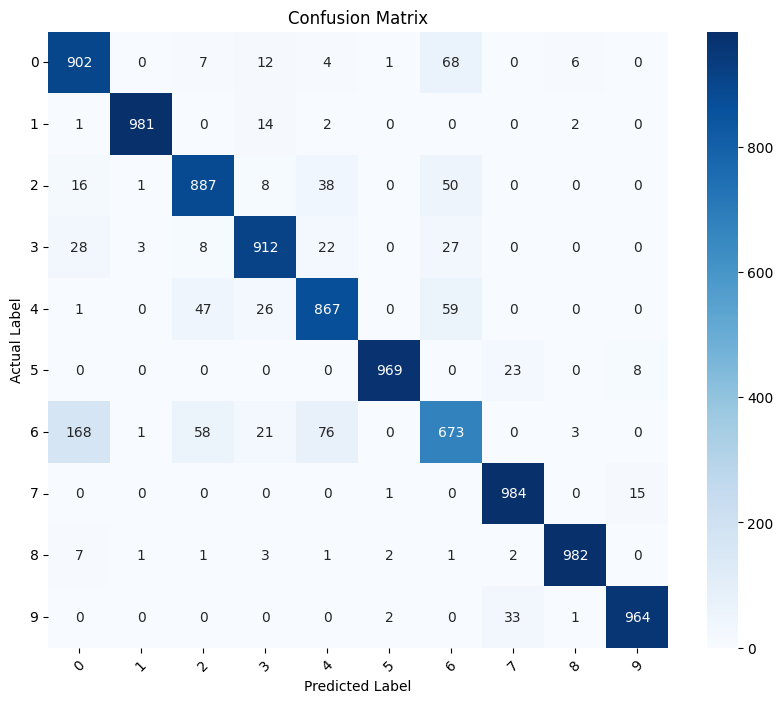

In [15]:
# Function to Get Predictions & Labels
def get_predictions(model, data_loader):
    all_preds = []
    all_labels = []

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get predicted class
            
            all_preds.extend(preds.cpu().numpy())  # Move to CPU for processing
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Get Predictions
actual_labels, predicted_labels = get_predictions(model, test_loader)

# Compute Confusion Matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## **Confusion Matrix Analysis**

The confusion matrix provides a detailed breakdown of the model’s performance across different categories. Key observations include:

- **Diagonal values** represent correctly classified instances for each class.
- **Misclassifications** are notably present in **class 6 (Shirt)**, which is often confused with **class 0 (T-shirt/top)**.
- The model performs exceptionally well in distinguishing **Sandals (class 5) and Sneakers (class 7)**, showing near-perfect classification.
- Overall, the model demonstrates strong classification performance, with minor errors in visually similar categories.


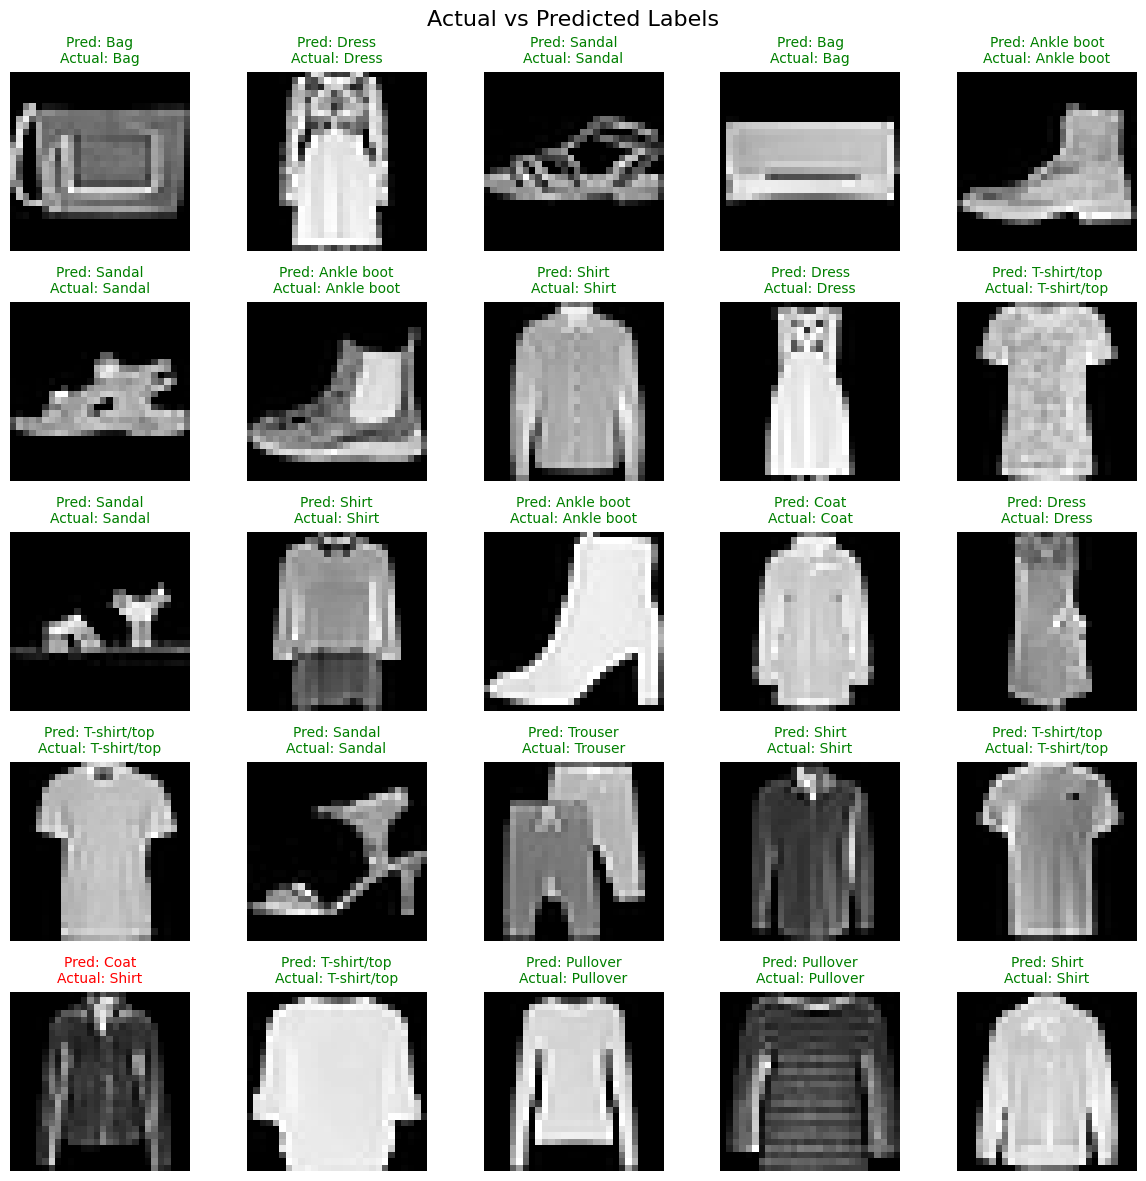

In [16]:

# Function to Plot Actual vs Predicted Labels
def plot_actual_vs_predicted(model, test_dataset, num_images=25):
    model.eval()
    
    # Select Random Samples from Test Set
    indices = random.sample(range(len(test_dataset)), num_images)
    sample_images = torch.stack([test_dataset[i][0] for i in indices])
    sample_labels = torch.tensor([test_dataset[i][1] for i in indices])
    
    # Move Data to Device
    sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)
    
    # Get Model Predictions
    with torch.no_grad():
        outputs = model(sample_images)
        _, predicted_labels = torch.max(outputs, 1)
    
    # Plot Images with Actual and Predicted Labels
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    fig.suptitle("Actual vs Predicted Labels", fontsize=16)

    for i, ax in enumerate(axes.flat):
        img = sample_images[i].cpu().numpy().reshape(28, 28)
        actual_label = LABELS[sample_labels[i].item()]
        predicted_label = LABELS[predicted_labels[i].item()]
        
        # Set Color Based on Correctness
        color = "green" if actual_label == predicted_label else "red"
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Pred: {predicted_label}\nActual: {actual_label}", color=color, fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Call Function to Plot Actual vs Predicted
plot_actual_vs_predicted(model, test_dataset)


## **Actual vs Predicted Labels Visualization**

### **Overview**
This visualization compares the **actual labels** with the **model’s predictions** for a random subset of test images. The goal is to assess the model’s performance at a glance.

### **Key Features**
- **25 random test images** are selected for evaluation.
- **Green labels** indicate correct predictions.
- **Red labels** highlight misclassified images.
- The images are displayed in grayscale with their respective **predicted** and **actual** labels.

### **Observations**
- The majority of predictions appear correct.
- Some misclassifications occur, particularly in.
- This visualization helps identify patterns in misclassification, which can guide further improvements to the model.

Would you like to explore **misclassified images separately** for deeper analysis? 📊


In [17]:
model.eval()

FashionCNN(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [18]:
torch.save(model.state_dict(), "fashion_mnist_weights.pth")

## **Saving the Trained Model Weights**

### **Overview**
After training the Fashion MNIST model, it is essential to save the learned weights for future use, avoiding the need for retraining.


In [19]:
# Save the entire model
torch.save(model, "fashion_mnist_model.pth")
print("Model saved successfully!")


Model saved successfully!


# Define hyperparameter

In [20]:
# Define hyperparameter ranges
learning_rates = [0.001, 0.01]
batch_sizes = [64, 128]
dropout_rates = [0.3, 0.5]

# Define Data Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



## Hyperparameter Selection  
Different values for learning rate, batch size, and dropout rate were tested to find the best combination. Learning rates of 0.001 and 0.01, batch sizes of 64 and 128, and dropout rates of 0.3 and 0.5 were chosen for tuning.  

## Data Preprocessing  
Images were converted to tensors and normalized to improve training stability. Normalization helps the model learn faster and perform better.


In [21]:
# Define CNN Model with Tunable Dropout
class FashionCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(dropout_rate)

        # Compute dynamically the input size for fc1
        self._to_linear = None
        self._compute_linear_input()

        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, 10)

    def _compute_linear_input(self):
        """Compute the number of flattened features dynamically."""
        with torch.no_grad():
            sample_input = torch.zeros(1, 1, 28, 28)
            output = self.pool(torch.relu(self.conv1(sample_input)))
            output = self.dropout(output)
            output = self.pool(torch.relu(self.conv2(output)))
            output = self.dropout(output)
            output = self.pool(torch.relu(self.conv3(output)))
            output = self.dropout(output)
            self._to_linear = output.numel()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.dropout(x)

        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define Training Function
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    return val_acc  # Return validation accuracy for comparison

# Define Evaluation Function
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


## CNN Hyper parameter Model for Fashion MNIST  
A custom CNN model was built with three convolutional layers, max pooling, and dropout for better generalization. The dropout rate is tunable to prevent overfitting.  

## Training Process  
The model was trained using cross-entropy loss and an optimizer. Accuracy and loss were monitored for each epoch. The model was validated using a separate dataset to check performance.  

## Model Evaluation  
The evaluation function tested the model on unseen data, measuring accuracy. The trained model was later used for predictions and analysis.


In [ ]:

# Hyperparameter Tuning Loop
best_acc = 0
best_params = None

# Iterate over all hyperparameter combinations
for lr, batch_size, dropout in itertools.product(learning_rates, batch_sizes, dropout_rates):
    print(f"\nTraining with lr={lr}, batch_size={batch_size}, dropout={dropout}")

    # Data Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize Model with Hyperparameters
    model = FashionCNN(dropout_rate=dropout).to(device)
    
    # Define Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train Model
    val_acc = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=epochs)

    # Check if this is the best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_params = (lr, batch_size, dropout)
        torch.save(model.state_dict(), "fashion_mnist_best_model.pth")  # Save best model
# Print Best Hyperparameters
print(f"\nBest Validation Accuracy: {best_acc:.4f}")
print(f"Best Hyperparameters - lr: {best_params[0]}, batch_size: {best_params[1]}, dropout: {best_params[2]}")



Training with lr=0.001, batch_size=64, dropout=0.3
Epoch 1/30, Loss: 0.5851, Train Acc: 0.7832, Val Acc: 0.8613
Epoch 2/30, Loss: 0.3752, Train Acc: 0.8599, Val Acc: 0.8845
Epoch 3/30, Loss: 0.3274, Train Acc: 0.8789, Val Acc: 0.9000
Epoch 4/30, Loss: 0.2991, Train Acc: 0.8911, Val Acc: 0.9041
Epoch 5/30, Loss: 0.2821, Train Acc: 0.8960, Val Acc: 0.9078
Epoch 6/30, Loss: 0.2696, Train Acc: 0.9006, Val Acc: 0.9168
Epoch 7/30, Loss: 0.2582, Train Acc: 0.9043, Val Acc: 0.9115
Epoch 8/30, Loss: 0.2471, Train Acc: 0.9093, Val Acc: 0.9176
Epoch 9/30, Loss: 0.2410, Train Acc: 0.9106, Val Acc: 0.9201
Epoch 10/30, Loss: 0.2353, Train Acc: 0.9130, Val Acc: 0.9191
Epoch 11/30, Loss: 0.2328, Train Acc: 0.9129, Val Acc: 0.9195
Epoch 12/30, Loss: 0.2200, Train Acc: 0.9177, Val Acc: 0.9229
Epoch 13/30, Loss: 0.2189, Train Acc: 0.9184, Val Acc: 0.9218
Epoch 14/30, Loss: 0.2154, Train Acc: 0.9192, Val Acc: 0.9203
Epoch 15/30, Loss: 0.2090, Train Acc: 0.9223, Val Acc: 0.9243
Epoch 16/30, Loss: 0.2045, 

## Hyperparameter Tuning  
Different learning rates, batch sizes, and dropout rates were tested to find the best combination. The model was trained multiple times, and validation accuracy was recorded for each run.  

## Best Model Selection  
The best-performing model was selected based on validation accuracy. The highest accuracy achieved was `93.17%` with a learning rate of `0.001`, batch size of `128`, and dropout rate of `0.3`.  

## Model Saving  
The best model was saved for future use to avoid retraining and ensure consistency in predictions.


In [23]:

# Train Final Model with Best Parameters
final_lr, final_batch_size, final_dropout = best_params
train_loader = DataLoader(train_dataset, batch_size=final_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=final_batch_size, shuffle=False)

hyper_model = FashionCNN(dropout_rate=final_dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(hyper_model.parameters(), lr=final_lr)


## Training the Final Model  
The best hyperparameters were used to train the final model:  
- **Learning Rate:** 0.001  
- **Batch Size:** 128  
- **Dropout Rate:** 0.3  

The model was trained again using these optimized settings to ensure the best possible performance.  


In [24]:

val_acc = train_model(hyper_model, train_loader, val_loader, optimizer, criterion, epochs)


# train_losses, train_accuracies = train_model(hyper_model, train_loader, val_loader,criterion, epochs)
# Train Final Model
# train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10)



Epoch 1/30, Loss: 0.6000, Train Acc: 0.7776, Val Acc: 0.8688
Epoch 2/30, Loss: 0.3700, Train Acc: 0.8632, Val Acc: 0.8897
Epoch 3/30, Loss: 0.3256, Train Acc: 0.8798, Val Acc: 0.8988
Epoch 4/30, Loss: 0.2961, Train Acc: 0.8930, Val Acc: 0.9042
Epoch 5/30, Loss: 0.2742, Train Acc: 0.8986, Val Acc: 0.9121
Epoch 6/30, Loss: 0.2593, Train Acc: 0.9041, Val Acc: 0.9117
Epoch 7/30, Loss: 0.2411, Train Acc: 0.9103, Val Acc: 0.9191
Epoch 8/30, Loss: 0.2338, Train Acc: 0.9128, Val Acc: 0.9236
Epoch 9/30, Loss: 0.2229, Train Acc: 0.9167, Val Acc: 0.9187
Epoch 10/30, Loss: 0.2149, Train Acc: 0.9205, Val Acc: 0.9251
Epoch 11/30, Loss: 0.2090, Train Acc: 0.9226, Val Acc: 0.9272
Epoch 12/30, Loss: 0.2037, Train Acc: 0.9244, Val Acc: 0.9263
Epoch 13/30, Loss: 0.1990, Train Acc: 0.9254, Val Acc: 0.9282
Epoch 14/30, Loss: 0.1965, Train Acc: 0.9256, Val Acc: 0.9303
Epoch 15/30, Loss: 0.1883, Train Acc: 0.9293, Val Acc: 0.9297
Epoch 16/30, Loss: 0.1851, Train Acc: 0.9301, Val Acc: 0.9312
Epoch 17/30, Loss

## Final Model Training Results  
After training the model with the best hyperparameters, we achieved:  
- **Training Accuracy:** `94.44%` 
- **Validation Accuracy:** `93.35%`  

The model performed well, showing strong generalization to unseen data.  


In [32]:
# Save Final Model
torch.save(hyper_model.state_dict(), "fashion_mnist_best_model_weights.pth")
print("\nFinal trained model saved as 'fashion_mnist_best_model.pth'")



Final trained model saved as 'fashion_mnist_best_model.pth'


## Model Saving  
The final trained model has been saved as:  
**fashion_mnist_best_model_weights.pth**  

This allows us to reuse the model for predictions without retraining.  


In [26]:
# torch.save(hyper_model, "fashion_mnist_best_model.pth")
# print("\nFinal trained model saved as 'fashion_mnist_best_model.pth'")



Final trained model saved as 'fashion_mnist_best_model.pth'


In [28]:
# model = torch.load("fashion_mnist_best_model.pth")
# model.eval()


FashionCNN(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
# Load the best saved model
model = FashionCNN().to(device)
model.load_state_dict(torch.load("/content/fashion_mnist_best_model_weights.pth"))
model.eval()

# Define DataLoader for Testing
test_loader = DataLoader(test_dataset, batch_size=final_batch_size, shuffle=False)

# Compute Final Test Accuracy
correct, total = 0, 0
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_labels).sum().item()
        total += batch_labels.size(0)

test_accuracy = correct / total
print(f"Final Test Accuracy: {test_accuracy:.4f}")


Final Test Accuracy: 0.9268


## Final Model Testing  
The best-trained model was loaded and evaluated on the test dataset.  

**Final Test Accuracy: `92.68%`**  

This confirms that our model performs well on unseen data.  


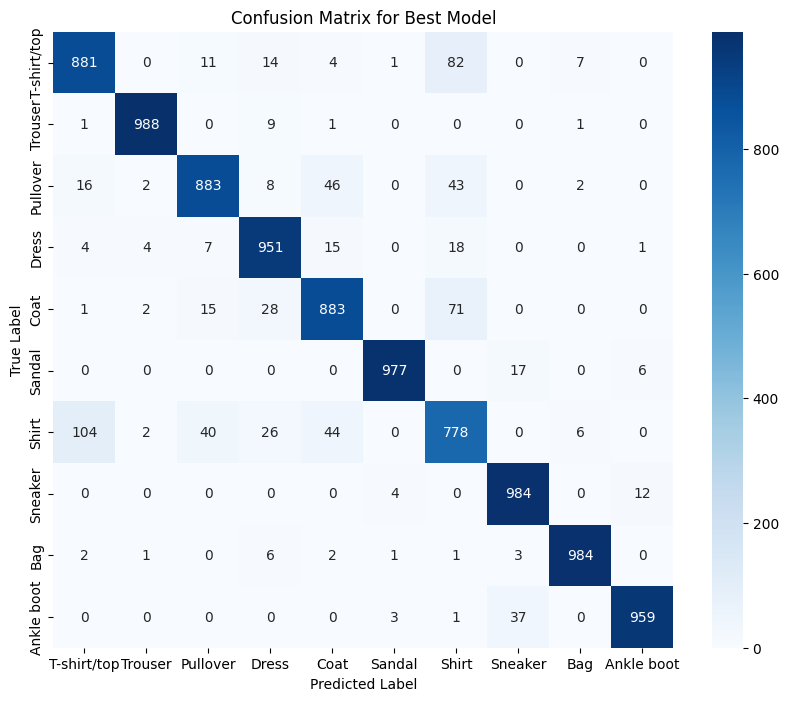

In [34]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())  # Convert to NumPy
        all_labels.extend(batch_labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Define class labels
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Best Model")
plt.show()

## Confusion Matrix Analysis  
The confusion matrix helps us understand the model's performance across different classes.  

- The diagonal values show correct predictions for each class.  
- Misclassifications are visible in off-diagonal values, such as **Shirt** being confused with **T-shirt/top**.  
- Overall, the model performs well.  


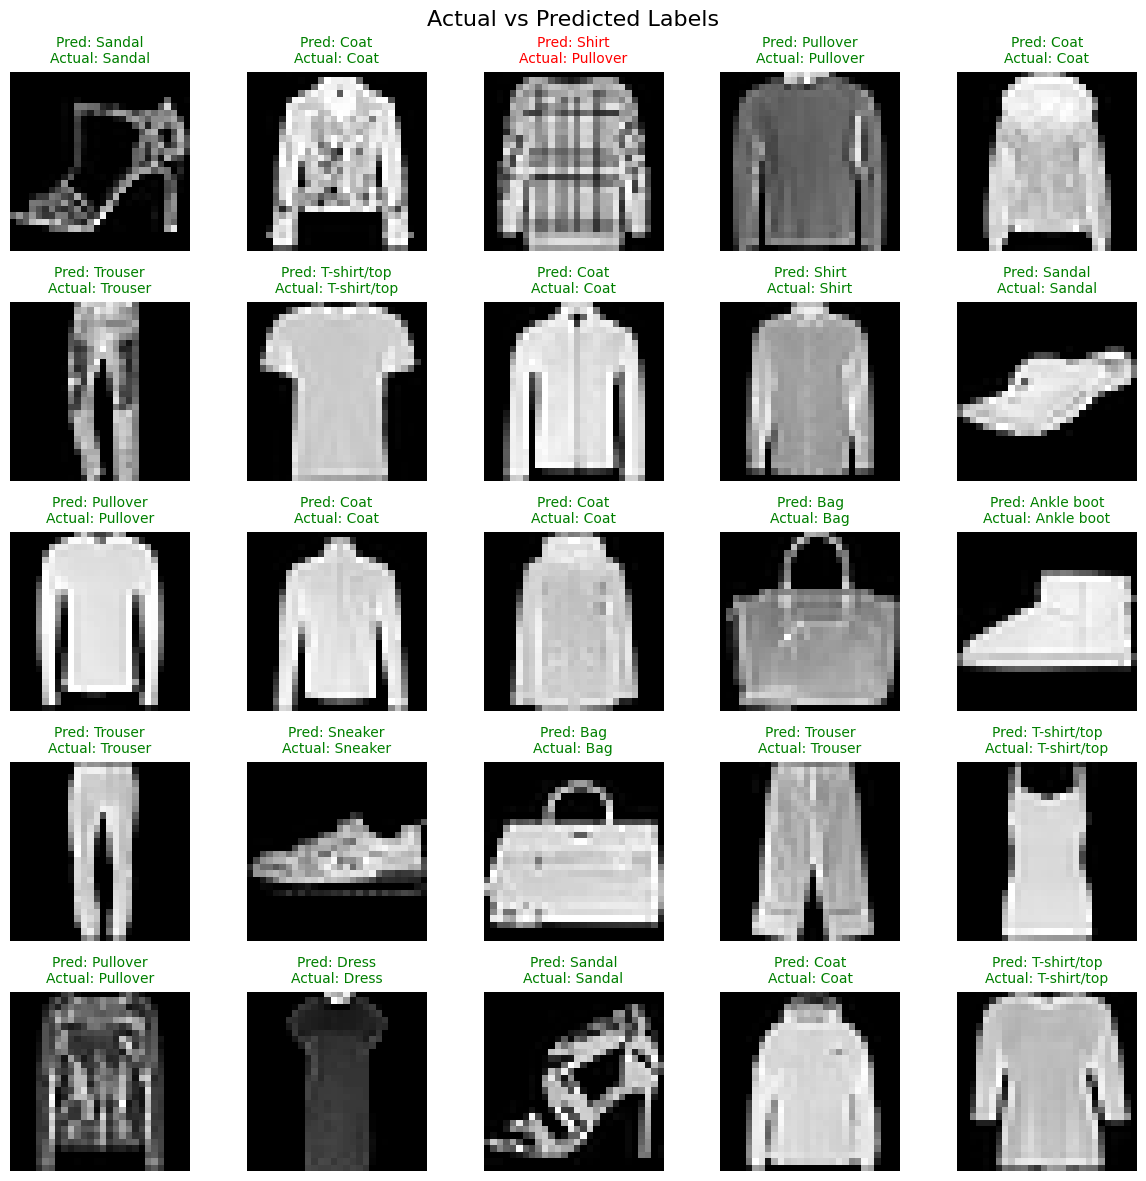

In [35]:
plot_actual_vs_predicted(model, test_dataset)

## Actual vs. Predicted Labels Plot

### Function to Visualize Predictions

The following function plots a 5×5 grid of images from the test dataset, displaying both the actual and predicted labels.
